# Imports and datafetching

In [4]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/My Drive/deeplearning/training_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [5]:
! pip install segmentation-models > /dev/null 2>&1

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from PIL import Image,  ImageOps
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split


#Check the version of TensorFlow you are using. Should be > 2.14.0
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Segmentation Models: using `tf.keras` framework.
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocessing

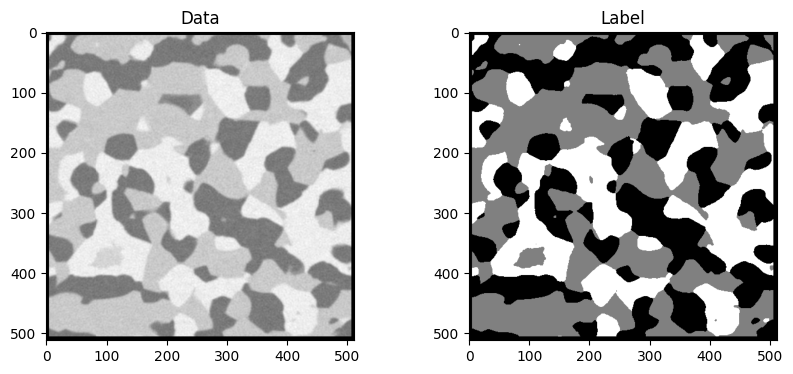

In [6]:
data_dir = os.path.join(drive_path, 'data')
labels_dir = os.path.join(drive_path, 'labels')


# Function for loading all the images in the dataset, and adding padding so that they all match the desired input size of 512x512
def load_and_resize_images(directory, target_size=(512, 512)):
    images = []
    file_names = os.listdir(directory)
    # Sorts to make sure the labels match the input images
    file_names.sort()
    for file_name in file_names:
        img_path = os.path.join(directory, file_name)
        img = Image.open(img_path)

        # Calculate padding
        old_size = img.size
        delta_w = target_size[0] - old_size[0]
        delta_h = target_size[1] - old_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

        # Apply padding
        new_img = ImageOps.expand(img, padding)

        # Convert to array
        new_img = image.img_to_array(new_img)
        images.append(new_img)

    # Returns the array of padded images from the dataset
    return np.array(images)

# Load and resize the images and labels
data_images = load_and_resize_images(data_dir)
label_images = load_and_resize_images(labels_dir)

# Checks that the images and labels has been correctly loaded
def display_sample(data, labels, index):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(data[index].squeeze(), cmap='gray')
    plt.title('Data')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[index].squeeze(), cmap='gray')
    plt.title('Label')
    plt.show()

# Display a random image and its label
display_sample(data_images, label_images, random.randint(1, len(data_images)))

## Mapping of grayscale to classes

In [7]:
def map_grayscale_to_class(labels):
    class_labels = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2]), dtype=np.int32)
    label_array = np.squeeze(labels)

    #Here, we define what grayscale should be black, gray or white
    class_labels[label_array <= 85] = 0  # Black
    class_labels[(label_array > 85) & (label_array <= 170)] = 1  # Gray
    class_labels[label_array > 170] = 2  # White
    return class_labels

# Converts labels to categoricals
train_labels_class = map_grayscale_to_class(label_images)
train_labels_categorical = to_categorical(train_labels_class, num_classes=3)

# Our models

## Self made U-Net model

In [8]:
def unet_model(input_size=(512, 512, 1), num_classes=3):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model1 = unet_model(input_size=(512, 512, 1), num_classes=3)

## ResNet34

In [9]:
# Implementation of the pre-existing, pre-trained resNet34 model
preprocess = get_preprocessing('resnet34')
model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')

## Compilation of U-Net and resNet34

In [10]:
# Training parameters
from tensorflow.keras.optimizers import legacy
optimizer = legacy.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Compiling our model (the commented is the resNet34)
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Training our model (the commented is the resNet34)
history_own_model = model1.fit(data_images, train_labels_categorical, batch_size=2, epochs=10, validation_split=0.2)
# history_resnet34 = model2.fit(data_images, train_labels_categorical, batch_size=2, epochs=3, validation_split=0.2)
history_resnet34 = model2.fit(data_images, train_labels_categorical, batch_size=2, epochs=2, validation_split=0.2)



Epoch 1/10
200/200 [==============================] - 21s 58ms/step - loss: 429.6213 - accuracy: 0.5553 - val_loss: 39.0450 - val_accuracy: 0.7581
Epoch 2/10
200/200 [==============================] - 10s 48ms/step - loss: 21.9040 - accuracy: 0.8408 - val_loss: 27.0241 - val_accuracy: 0.8172
Epoch 3/10
200/200 [==============================] - 10s 52ms/step - loss: 11.3705 - accuracy: 0.8912 - val_loss: 15.9910 - val_accuracy: 0.8745
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 8.4501 - accuracy: 0.9099 - val_loss: 13.4943 - val_accuracy: 0.8896
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 7.2930 - accuracy: 0.9181 - val_loss: 14.9054 - val_accuracy: 0.8644
Epoch 6/10
200/200 [==============================] - 10s 48ms/step - loss: 5.2504 - accuracy: 0.9354 - val_loss: 10.6523 - val_accuracy: 0.9064
Epoch 7/10
200/200 [==============================] - 9s 47ms/step - loss: 4.9898 - accuracy: 0.9369 - val_loss: 10.4515 - val

## Visualization of accuracy and loss per epoch
Showing for U-Net

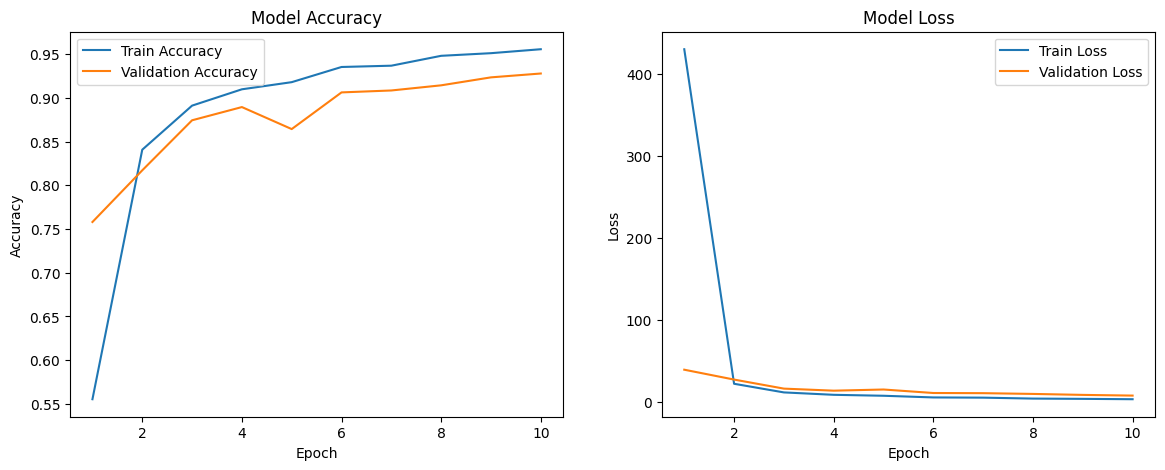

In [11]:
# Finds the amount of epochs used
epochs = range(1, len(history_own_model.history['accuracy']) + 1)

# Plots training & validation accuracies
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_own_model.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history_own_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plots training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history_own_model.history['loss'], label='Train Loss')
plt.plot(epochs, history_own_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Visualization of the predicted label

1/1 [==============================] - 1s 1s/step


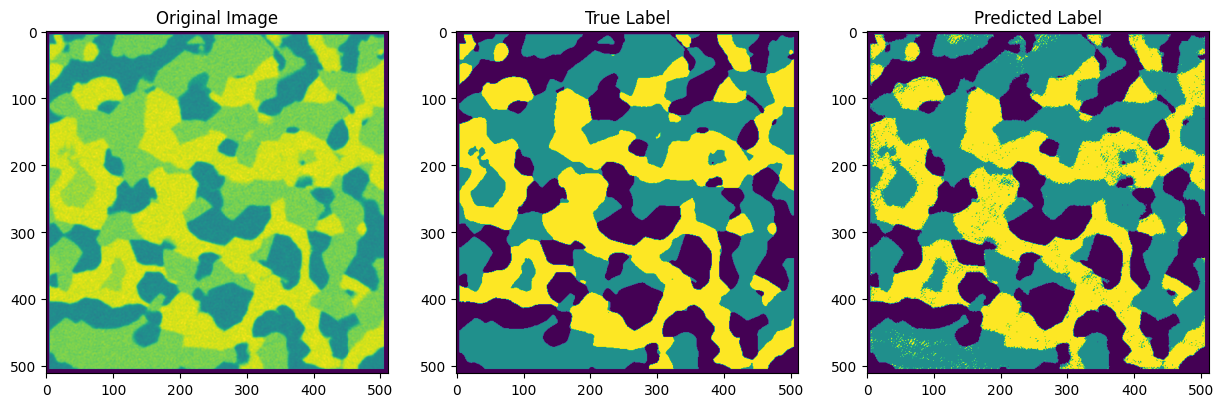

1/1 [==============================] - 3s 3s/step


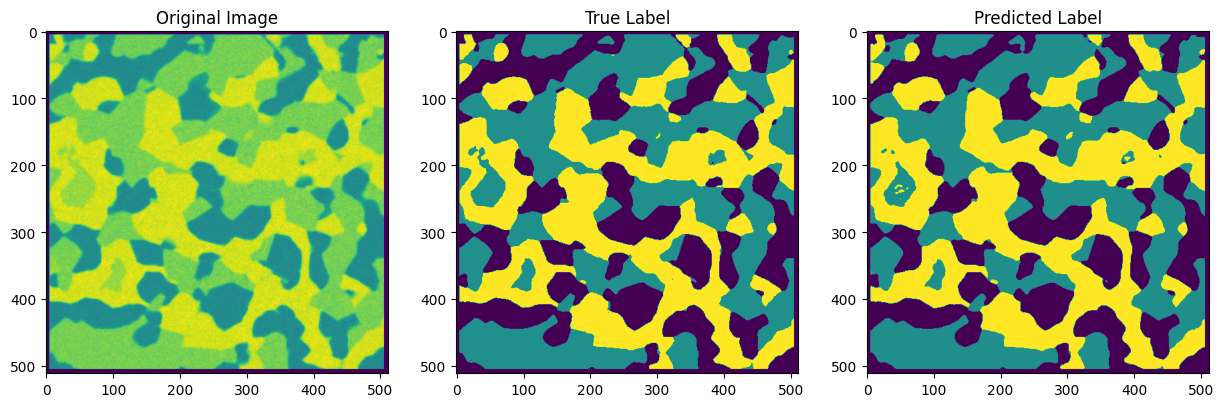

In [12]:
def plot_example(model, index_to_visualize=234):
    # Select a sample to visualize
    index_to_visualize = index_to_visualize  # Can be any valid index of an image in the dataset

    # Get the model's prediction
    predicted_categorical = model.predict(np.expand_dims(data_images[index_to_visualize], axis=0))
    predicted_class = np.argmax(predicted_categorical, axis=-1)  # Get the class with the highest probability

    # Convert the predicted classes back to a grayscale image
    # Create a mapping for classes to grayscale values
    class_to_grayscale = {0: 0, 1: 127, 2: 255}
    # Vectorize the mapping to apply it over the predicted class array
    vectorized_mapping = np.vectorize(class_to_grayscale.get)
    predicted_grayscale = vectorized_mapping(predicted_class.squeeze()).astype(np.uint8)

    # Now let's visualize the original image, the true label, and the predicted label side by side
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(data_images[index_to_visualize].squeeze())
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    # Assuming label_images are already in the correct grayscale format (0, 127, 255)
    true_label_grayscale = label_images[index_to_visualize].squeeze().astype(np.uint8)
    plt.imshow(true_label_grayscale)
    plt.title('True Label')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_grayscale)
    plt.title('Predicted Label')

    plt.show()


display(HTML("<h4>Our own model</h4>"))
plot_example(model1)


display(HTML("<h4>resnet34-model</h4>"))
plot_example(model2)

# Reducing the training data
Gaining data used for x-ray segmentation can be difficult. We want to find out the least amount of data we can use while keeping our model accurate.

## Splitting the dataset into training and validation set
We want to test out training with only one image

In [17]:
random.seed(42)

# Randomly select 1 example for training and 500 for validation
# First, generate random unique indices
indices = np.random.permutation(len(data_images))
train_indices = indices[:1]  # First index for training
val_indices = indices[1:500]  # Next 500 indices for validation

# Split the data
data_train = data_images[train_indices]
labels_train = train_labels_categorical[train_indices]

data_val = data_images[val_indices]
labels_val = train_labels_categorical[val_indices]


normal_datagen = ImageDataGenerator()

## Training models with 1 image


In [35]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import legacy

# Dictionary to store histories
histories = {'model1': {}, 'model2': {}}

# Preprocess the data for the resnet34-model (model2)
preprocess = get_preprocessing('resnet34')
pre_data_train = preprocess(data_train)
pre_data_val = preprocess(data_val)

# Validation generators for model1 and model2
validation_generator1 = normal_datagen.flow(data_val, labels_val, batch_size=1)
validation_generator2 = normal_datagen.flow(pre_data_val, labels_val, batch_size=1)

# The model we have designed ourself (model1)
model1 = unet_model(input_size=(512, 512, 1), num_classes=3)

# The resnet34-model (model2)
model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')

# Parameters for both models
optimizer = legacy.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Compile the models
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Custom callback function that only calculates validation accuracy each n-th iteration, in order to save time
class NthEpochEvaluation(Callback):
    def __init__(self, val_generator, n=10):
        super().__init__()
        self.val_generator = val_generator
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            val_loss, val_acc = self.model.evaluate(self.val_generator, verbose=0)
            logs['val_loss'] = val_loss
            logs['val_accuracy'] = val_acc

# Create an instance of the custom callback, set n to the desired interval
# We do this to make the training faster

# nth_epoch is how often we calculate validation acc
nth_epoch = 25

nth_epoch_eval1 = NthEpochEvaluation(validation_generator1, n=nth_epoch)
nth_epoch_eval2 = NthEpochEvaluation(validation_generator2, n=nth_epoch)



In [36]:
train1 = normal_datagen.flow(data_train[:1], labels_train[:1], batch_size=1)
train2 = normal_datagen.flow(pre_data_train[:1], labels_train[:1], batch_size=1)

# Train model1
history1 = model1.fit(train1, epochs=400, batch_size=1, callbacks=[nth_epoch_eval1])
histories['model1'] = history1

# Train model2
history2 = model2.fit(train2, epochs=400, batch_size=1, callbacks=[nth_epoch_eval2])
histories['model2'] = history2

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 2368.3013 - accuracy: 0.3077
Epoch 2/500
1/1 [==============================] - 0s 54ms/step - loss: 2098.1167 - accuracy: 0.3090
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 1824.0212 - accuracy: 0.3110
Epoch 4/500
1/1 [==============================] - 0s 54ms/step - loss: 1564.1099 - accuracy: 0.3260
Epoch 5/500
1/1 [==============================] - 0s 55ms/step - loss: 1415.7653 - accuracy: 0.3552
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 1294.9015 - accuracy: 0.3661
Epoch 7/500
1/1 [==============================] - 0s 52ms/step - loss: 1171.9541 - accuracy: 0.3844
Epoch 8/500
1/1 [==============================] - 0s 49ms/step - loss: 1072.4857 - accuracy: 0.3737
Epoch 9/500
1/1 [==============================] - 0s 50ms/step - loss: 1003.2853 - accuracy: 0.3630
Epoch 10/500
1/1 [==============================] - 0s 53ms/step - loss: 944.9182 - accuracy:

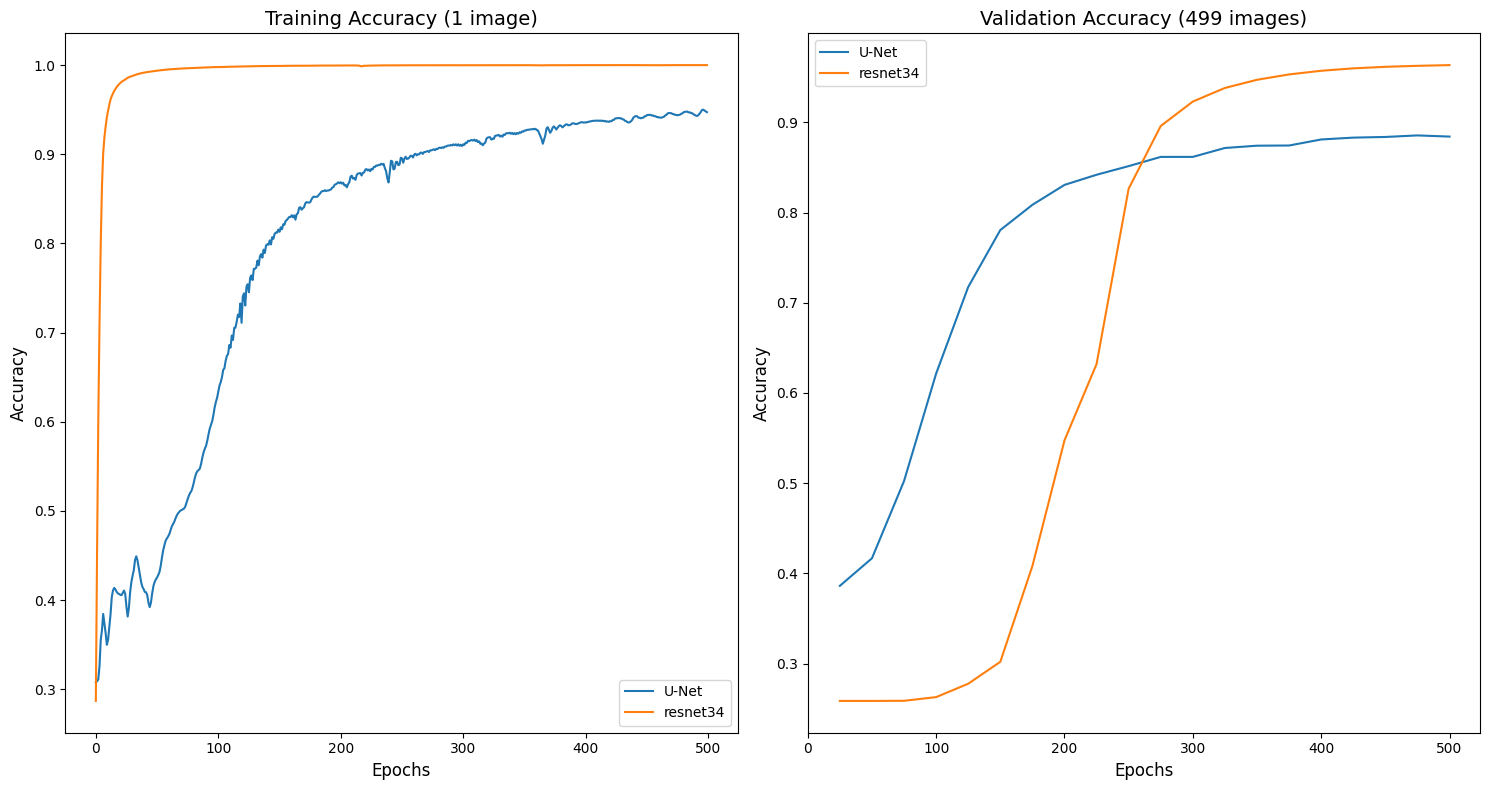

In [39]:
plt.figure(figsize=(15, 8))  # Increased from (10, 4) to (15, 8)

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(histories['model1'].history['accuracy'], label='U-Net')
plt.plot(histories['model2'].history['accuracy'], label='resnet34')
plt.title(f'Training Accuracy (1 image)', fontsize=14)  # Adjust font size if needed
plt.xlabel('Epochs', fontsize=12)  # Adjust font size if needed
plt.ylabel('Accuracy', fontsize=12)  # Adjust font size if needed
plt.legend(fontsize=10)  # Adjust font size if needed

# Assuming histories contain validation accuracies for every 25th epoch
model1_val_acc = histories['model1'].history['val_accuracy']
model2_val_acc = histories['model2'].history['val_accuracy']

# Number of points plotted
num_points = len(model1_val_acc)

# Create an array representing the actual epoch numbers
epochs = [(i+1) * nth_epoch for i in range(num_points)]
x_ticks = [0, 100, 200, 300, 400]  # Adjust this based on your accuracy range

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, model1_val_acc, label='U-Net')
plt.plot(epochs, model2_val_acc, label='resnet34')
plt.title(f'Validation Accuracy (499 images)', fontsize=14)  # Adjust font size if needed
plt.xlabel('Epochs', fontsize=12)  # Adjust font size if needed
plt.ylabel('Accuracy', fontsize=12)  # Adjust font size if needed
plt.xticks(epochs)  # Set x-ticks to be the actual epoch numbers
plt.legend(fontsize=10)  # Adjust font size if neede


plt.xticks(x_ticks)  # Set x-ticks to be the actual epoch numbers

plt.tight_layout()
plt.show()


Performance looks great, but can we improve it further?

# Data Augmentation
We want to investigate if we can improve our models performance by doing changes to our one training example

## Implementing augmentation
We implement augmentation by flipping each image 4 times, and therefore expanding our trainingset by x4

In [21]:
import numpy as np

def augment_images_and_labels(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        # Original image and label
        augmented_images.append(image)
        augmented_labels.append(label)

        # Rotate 90 degrees
        rotated_90_image = np.rot90(image)
        rotated_90_label = np.rot90(label)
        augmented_images.append(rotated_90_image)
        augmented_labels.append(rotated_90_label)

        # Rotate 180 degrees
        rotated_180_image = np.rot90(rotated_90_image)
        rotated_180_label = np.rot90(rotated_90_label)
        augmented_images.append(rotated_180_image)
        augmented_labels.append(rotated_180_label)

        # Rotate 270 degrees
        rotated_270_image = np.rot90(rotated_180_image)
        rotated_270_label = np.rot90(rotated_180_label)
        augmented_images.append(rotated_270_image)
        augmented_labels.append(rotated_270_label)

    return np.array(augmented_images), np.array(augmented_labels)

# Assuming data_train and labels_train are your original training datasets
augmented_data_train, augmented_labels_train = augment_images_and_labels(data_train, labels_train)


## Comparing the two models with and without data augmentation
Note: running all of theses is time consuming

In [ ]:
# Augmentation
model1 = unet_model(input_size=(512, 512, 1), num_classes=3)
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
train_aug = normal_datagen.flow(augmented_data_train, augmented_labels_train, batch_size=1)
unet_training_with_augmentation = model1.fit(train_aug, epochs=400, batch_size=1, callbacks=[nth_epoch_eval1])

model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')
model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
pre_augmented_data_train = preprocess(augmented_data_train)
train_aug = normal_datagen.flow(pre_augmented_data_train, augmented_labels_train, batch_size=1)
resnet_training_with_augmentation = model2.fit(train_aug, epochs=400, batch_size=1, callbacks=[nth_epoch_eval2])

# No augemntation
model3 = unet_model(input_size=(512, 512, 1), num_classes=3)
model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)
train = normal_datagen.flow(data_train, labels_train, batch_size=1)
unet_training_without_augmentation = model3.fit(train, epochs=400, batch_size=1, callbacks=[nth_epoch_eval1])

model4 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')
model4.compile(optimizer=optimizer, loss=loss, metrics=metrics)
pre_data_train = preprocess(data_train)
train = normal_datagen.flow(pre_data_train, labels_train, batch_size=1)
resnet_training_without_augmentation = model4.fit(train, epochs=400, batch_size=1, callbacks=[nth_epoch_eval2])


## Plotting the accuracies over epochs

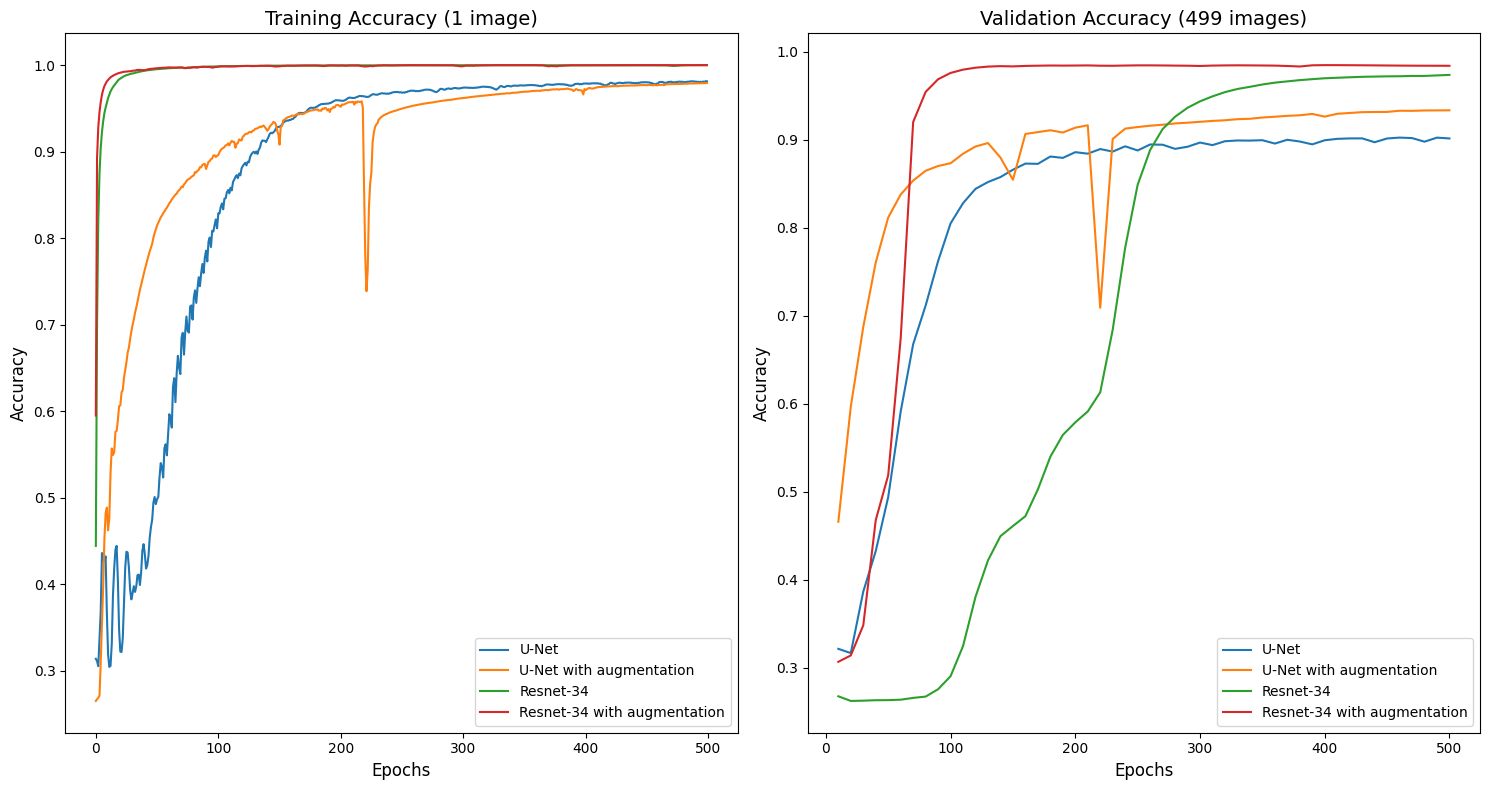

In [ ]:
plt.figure(figsize=(15, 8))  # Increased from (10, 4) to (15, 8)

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(unet_training_without_augmentation.history['accuracy'], label='U-Net')
plt.plot(unet_training_with_augmentation.history['accuracy'], label='U-Net with augmentation')
plt.plot(resnet_training_without_augmentation.history['accuracy'], label='Resnet-34')
plt.plot(resnet_training_with_augmentation.history['accuracy'], label='Resnet-34 with augmentation')
plt.title(f'Training Accuracy (1 image)', fontsize=14)  # Adjust font size if needed
plt.xlabel('Epochs', fontsize=12)  # Adjust font size if needed
plt.ylabel('Accuracy', fontsize=12)  # Adjust font size if needed
plt.legend(fontsize=10)  # Adjust font size if needed

# Assuming histories contain validation accuracies for every 25th epoch
unet_training_without_augmentation_val_acc = unet_training_without_augmentation.history['val_accuracy']
unet_training_with_augmentation_val_acc = unet_training_with_augmentation.history['val_accuracy']
resnet_training_without_augmentation_val_acc = resnet_training_without_augmentation.history['val_accuracy']
resnet_training_with_augmentation_val_acc = resnet_training_with_augmentation.history['val_accuracy']

# Number of points plotted
num_points = len(unet_training_without_augmentation_val_acc)

# Create an array representing the actual epoch numbers
epochs = [(i+1) * nth_epoch for i in range(num_points)]

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, unet_training_without_augmentation_val_acc, label='U-Net')
plt.plot(epochs, unet_training_with_augmentation_val_acc, label='U-Net with augmentation')
plt.plot(epochs, resnet_training_without_augmentation_val_acc, label='Resnet-34')
plt.plot(epochs, resnet_training_with_augmentation_val_acc, label='Resnet-34 with augmentation')
plt.title(f'Validation Accuracy (499 images)', fontsize=14)  # Adjust font size if needed
plt.xlabel('Epochs', fontsize=12)  # Adjust font size if needed
plt.ylabel('Accuracy', fontsize=12)  # Adjust font size if needed

x_ticks = [0, 100, 200, 300, 400, 500]  # Adjust this based on your accuracy range
plt.xticks(x_ticks)  # Set x-ticks to be the actual epoch numbers
plt.legend(fontsize=10)  # Adjust font size if neede

plt.tight_layout()
plt.show()


## Accuracy table

In [ ]:
def print_accuracy_table(histories):
    """
    Prints a table of the accuracies for the last epoch from given training histories.

    :param histories: A dictionary where keys are model descriptions and values are training history objects.
    """
    # Define the headers for the table
    headers = ["Model", "Last Epoch Train Accuracy", "Last Epoch Validation Accuracy"]

    # Initialize an empty list for table rows
    rows = []

    # Iterate through each history object and retrieve the last epoch accuracies
    for model_description, history in histories.items():
        last_epoch_train_accuracy = history.history['accuracy'][-1]
        last_epoch_val_accuracy = history.history['val_accuracy'][-1]
        rows.append([model_description, last_epoch_train_accuracy, last_epoch_val_accuracy])

    # Print the table
    print("{:<40} {:<30} {:<30}".format(*headers))
    for row in rows:
        print("{:<40} {:<30} {:<30}".format(*row))

# Example usage
histories = {
    "UNet Without Augmentation": unet_training_without_augmentation,
    "UNet With Augmentation": unet_training_with_augmentation,
    "ResNet Without Augmentation": resnet_training_without_augmentation,
    "ResNet With Augmentation": resnet_training_with_augmentation
}

print_accuracy_table(histories)

Model                                    Last Epoch Train Accuracy      Last Epoch Validation Accuracy
UNet Without Augmentation                0.9812545776367188             0.9013161063194275            
UNet With Augmentation                   0.979344367980957              0.9332596063613892            
ResNet Without Augmentation              0.999969482421875              0.9734711050987244            
ResNet With Augmentation                 0.999995231628418              0.9838131666183472            


## Display and predict a image

Using the four different approaches, we want to visualize the original image, true label, and predicted label

# unet_training_without_augmentation
1/1 [==============================] - 0s 18ms/step


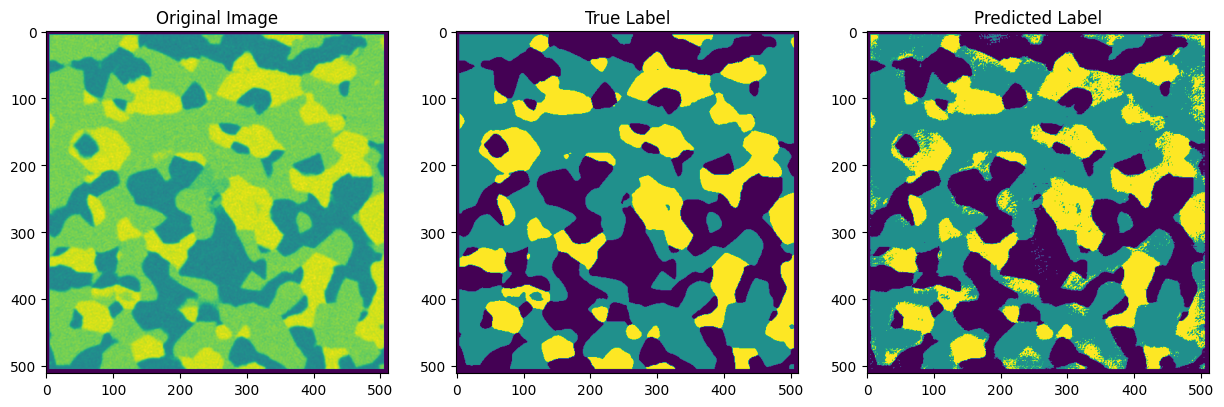

unet_training_with_augmentation
1/1 [==============================] - 0s 36ms/step


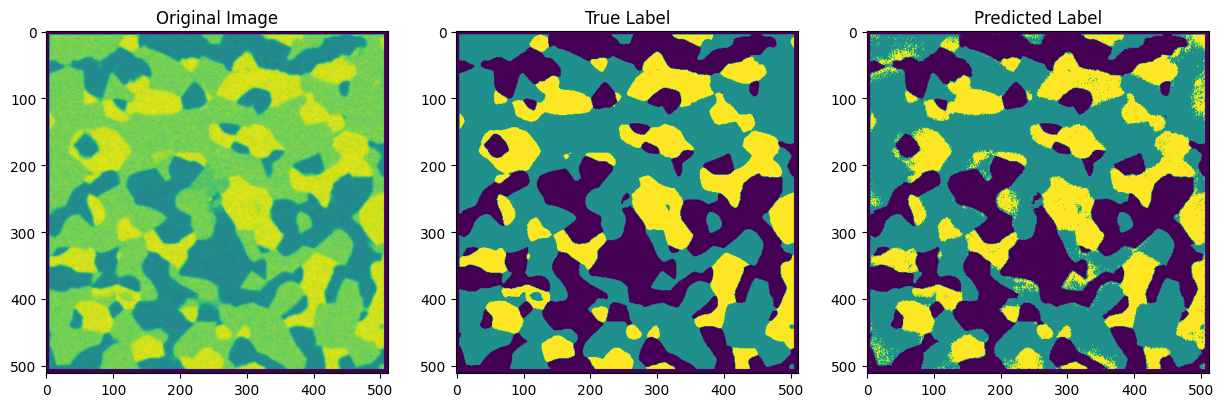

resnet_training_without_augmentation
1/1 [==============================] - 0s 33ms/step


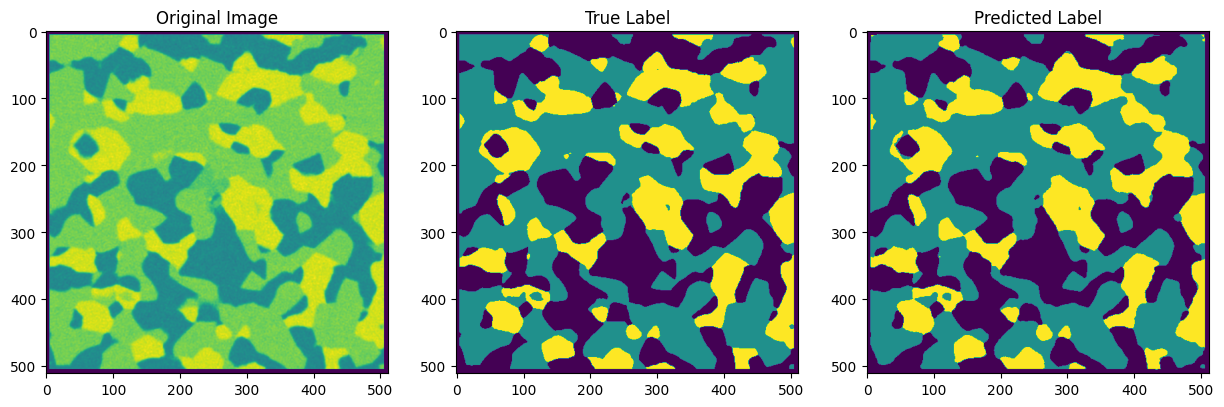

resnet_training_with_augmentation
1/1 [==============================] - 0s 39ms/step


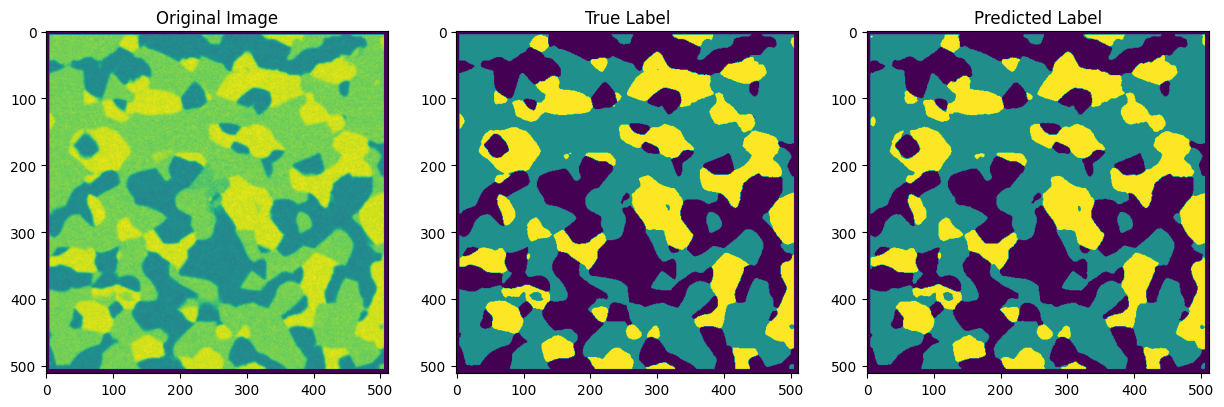

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

index=105

print("# unet_training_without_augmentation")
# unet_training_without_augmentation
plot_example(model3, index_to_visualize=index)

print("unet_training_with_augmentation")
# unet_training_with_augmentation
plot_example(model1, index_to_visualize=index)

print("resnet_training_without_augmentation")
# resnet_training_without_augmentation
plot_example(model4, index_to_visualize=index)

print("resnet_training_with_augmentation")
# resnet_training_with_augmentation
plot_example(model2, index_to_visualize=index)



# Adding Noise + reduced training data + augmented data
We want to add noise to an image and then check the accuracy on the model

In [ ]:
# Code for noise - use model2 that was initialized over, or just train the model again:

# model2 = Unet('resnet34', encoder_weights=None, input_shape=(512, 512, 1), classes=3, activation='softmax')
# model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# pre_augmented_data_train = preprocess(augmented_data_train)
# print(len(pre_augmented_data_train)) # should be 4 (1 image rotated 4 times)
# train_aug = normal_datagen.flow(pre_augmented_data_train, augmented_labels_train, batch_size=1)
# resnet_training_with_augmentation = model2.fit(train_aug, epochs=500, batch_size=1, callbacks=[nth_epoch_eval2])

